# test_longmodel.ipynb
6.28.24
we have th elong sequences, but can we actually calculate the loss and evaluate them?

We get NAN as well?

In [1]:
import torch
import sys
import yaml 
from tqdm import tqdm
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.tasks.decoders import SequenceDecoder
import pytorch_lightning as pl
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from torch.utils.data import DataLoader
import torch.nn as nn
from src.dataloaders.datasets.ccre_dataset import CcreDataset
from src.models.sequence.long_conv_lm import ConvLMHeadModel
from src.tasks.decoders import ProfileDecoder
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [2]:

from src.dataloaders.datasets.profile_atac_long import ProfileATACLong
dataset = ProfileATACLong(max_length = 32768, split = 'test', rc_aug = False, add_eos='False')

In [12]:
cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/profile_long.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-06-27/22-10-40-603095/checkpoints/02-val_loss=nan.ckpt'
# train_cfg = cfg['train']
model_cfg = cfg['model_config']
# d_output = train_cfg['d_output']
d_output=1
backbone = DNAEmbeddingModel(**model_cfg)
decoder = ProfileDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')
state_dict = torch.load(ckpt_path, map_location='cpu')
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)
# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
decoder_state_dict['output_transform_counts.weight'] = model_state_dict.pop('decoder.0.output_transform_counts.weight')
decoder_state_dict['output_transform_counts.bias'] = model_state_dict.pop('decoder.0.output_transform_counts.bias')
decoder_state_dict['output_transform_profile.weight'] = model_state_dict.pop('decoder.0.output_transform_profile.weight')
decoder_state_dict['output_transform_profile.bias'] = model_state_dict.pop('decoder.0.output_transform_profile.bias')
# else:
#     for key in list(model_state_dict.keys()):
#         if 'decoder' in key:
#             decoder_state_dict[key[10:]] = model_state_dict.pop(key) #still gotta test this, but I think it'll work
# now actually load the state dict to the decoder and backbone separately
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)
decoder = decoder.to(device).eval()
backbone = backbone.to(device).eval()

In [13]:
backbone

DNAEmbeddingModel(
  (backbone): LMBackbone(
    (embeddings): GPT2Embeddings(
      (word_embeddings): Embedding(16, 256)
    )
    (layers): ModuleList(
      (0): Block(
        (mixer): CheckpointedModule(
          (layer): HyenaOperator(
            (activation): Identity()
            (dropout): Dropout(p=0.0, inplace=False)
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
            (in_proj): Linear(in_features=256, out_features=768, bias=True)
            (short_filter): Conv1d(768, 768, kernel_size=(3,), stride=(1,), padding=(2,), groups=768)
            (filter_fn): HyenaFilter(
              (dropout): Dropout(p=0.0, inplace=False)
              (pos_emb): PositionalEmbedding()
              (implicit_filter): Sequential(
                (0): Linear(in_features=5, out_features=64, bias=True)
                (1): Sin()
                (2): Linear(in_features=64, out_features=64, bias=True)
                (3): Sin()
                (4): Linear(i

In [16]:
decoder.output_transform_profile.weight
#so it's an actual tensor, that's strange?

Parameter containing:
tensor([[-0.0462,  0.0120,  0.0463, -0.0072,  0.0196, -0.0056,  0.0195,  0.0675,
         -0.0813, -0.0034, -0.0821,  0.0605,  0.0293, -0.0058,  0.0180,  0.0102,
         -0.0426, -0.0343,  0.0057, -0.0557, -0.1001, -0.0180, -0.0139,  0.0937,
         -0.0672, -0.0888, -0.0081,  0.0016, -0.0104, -0.0576, -0.1007, -0.0131,
         -0.0526, -0.1521, -0.0609, -0.0434,  0.0529, -0.0026, -0.0025,  0.0894,
          0.0887, -0.0157, -0.0158,  0.0172, -0.0174, -0.0231,  0.0565, -0.1024,
          0.0595, -0.0787, -0.0053, -0.0532,  0.0305, -0.0249, -0.1004,  0.0181,
         -0.0076,  0.0232,  0.0396,  0.0144, -0.0626, -0.1114, -0.0718, -0.0412,
          0.0099, -0.0045,  0.0358, -0.0271,  0.0134,  0.0191, -0.0676, -0.0520,
          0.0297,  0.0790, -0.0964,  0.0433, -0.0284,  0.0861, -0.0038, -0.0773,
          0.0252, -0.1217, -0.0976,  0.0773, -0.0763,  0.0078, -0.0200,  0.0748,
         -0.0255, -0.0126,  0.1289,  0.0902, -0.1132, -0.0072, -0.0740,  0.0080,
      

In [22]:
#now let's try to evaluate the model
test_input = dataset[0][0][0]
print(test_input)
out1 = backbone(test_input.unsqueeze(0).to(device))
print(out1)
out2 = decoder(out1[0])
print(out2)

tensor([ 8, 10, 10,  ...,  7, 10,  7])
(tensor([[[ 3.2531e-01, -1.8607e-01, -2.0956e-01,  ...,  4.0784e-01,
           1.9625e-04,  3.4466e-01],
         [ 2.2169e-01, -2.5695e-01,  7.2452e-02,  ...,  2.8835e-01,
           4.7627e-02,  6.3097e-01],
         [ 2.0839e-01, -2.7302e-01,  1.0199e-01,  ...,  2.7405e-01,
           4.8803e-02,  6.3285e-01],
         ...,
         [ 2.2422e-01, -2.4895e-01,  3.7370e-01,  ..., -1.3680e-01,
          -2.1063e-01,  6.7478e-01],
         [ 1.4735e-01,  3.0847e-02,  4.6600e-01,  ..., -2.4606e-01,
          -1.8018e-01,  7.5945e-01],
         [ 1.5574e-01, -2.7855e-01,  4.0311e-01,  ..., -1.5801e-01,
          -2.4457e-01,  4.5950e-01]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>), None)
(tensor([[[-0.3110],
         [ 0.2631],
         [ 0.3053],
         ...,
         [-0.9357],
         [-1.7708],
         [ 0.4601]]], device='cuda:0', grad_fn=<ViewBackward0>), tensor([[9.0320]], device='cuda:0', grad_fn=<AddmmBackward0>))


In [23]:
#now we can calculate the loss?
print(out2[1],dataset[0][1][1]) #definitely a bit off, but that's fine!

tensor([[9.0320]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([8.0150])


In [27]:
print(out2[0].shape)
print(out2[0].squeeze().shape)
print(dataset[0][1][0].shape)

torch.Size([1, 32768, 1])
torch.Size([32768])
torch.Size([32768])


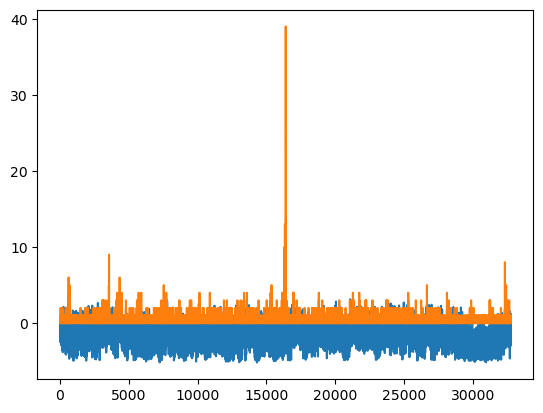

In [28]:
#and see the profile outputs
import matplotlib.pyplot as plt
plt.plot(out2[0].squeeze().detach().cpu().numpy())
plt.plot(dataset[0][1][0].detach().cpu().numpy())

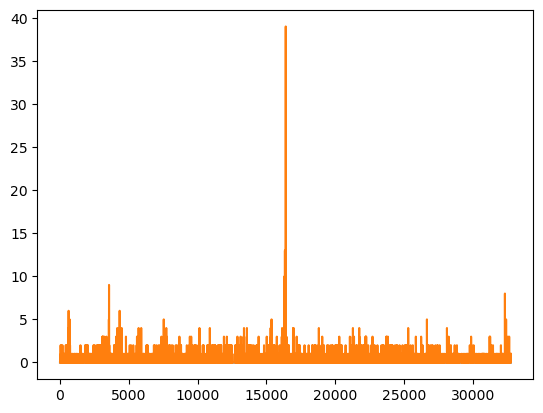

In [31]:
#and now do the softmax
plt.plot(out2[0].squeeze().softmax(dim=0).detach().cpu().numpy())
plt.plot(dataset[0][1][0].detach().cpu().numpy())

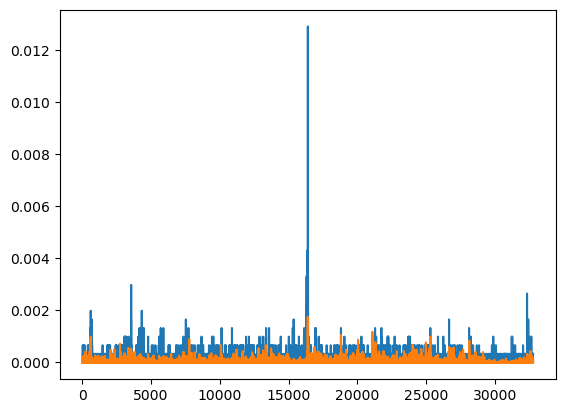

In [34]:
#wait wrong scales
plt.plot(dataset[0][1][0].detach().cpu().numpy()/dataset[0][1][0].sum())
plt.plot(out2[0].squeeze().softmax(dim=0).detach().cpu().numpy())

#it's honestly not even that bad??

In [35]:
#let's set up a quick loop to calculate a nan
dataset = ProfileATACLong(max_length = 32768, split = 'val', rc_aug = False, add_eos='False')
dataloader = DataLoader(dataset, batch_size=2, shuffle=False, num_workers=1)

In [36]:
#now make a quick loop where we evaluate our models, this is our loss functions
import torch.nn.functional as F
def cbpnet_multinomial_nll(logits,true_counts, len_batch=None, ignore_index=-100, mask = True):

    """A loss function based on the multinomial negative log-likelihood.
    modified by me to include things like doing thE log softmax and deal with more complex tracking

    This loss function takes in a tensor of normalized log probabilities such
    that the sum of each row is equal to 1 (e.g. from a log softmax) and
    an equal sized tensor of true counts and returns the probability of
    observing the true counts given the predicted probabilities under a
    multinomial distribution. Can accept tensors with 2 or more dimensions
    and averages over all except for the last axis, which is the number
    of categories.

    Adapted from Alex Tseng.

    Parameters
    ----------
    logps: torch.tensor, shape=(n, ..., L)
        A tensor with `n` examples and `L` possible categories. 

    true_counts: torch.tensor, shape=(n, ..., L)
        A tensor with `n` examples and `L` possible categories.

    Returns
    -------
    loss: float
        The multinomial log likelihood loss of the true counts given the
        predicted probabilities, averaged over all examples and all other
        dimensions.
    """
    if isinstance(logits, tuple) or isinstance(logits,list): #for wandb tracking, it inputs logits here, since then it's a tuple
        logits = logits[0]
        true_counts = true_counts[0]
    # if true_counts.shape[1] > logits.shape[1]: #then we cut off from both ends until we get the same size because of wandb again
    #     true_counts = true_counts[:,:-1] #because we appended the counts to the end, so remove it for this loss
    #     logits = logits[0]
    #we also need to make sure that we have the right shape
    logits = logits.squeeze(); true_counts = true_counts.squeeze()
    # if logits.shape[1] > true_counts.shape[1]: #added it in the tasks instead
    #     #then we cut off from both ends until we get the same size
    #     diff = logits.shape[1] - true_counts.shape[1]
    #     start = diff // 2
    #     end = start + true_counts.shape[1]
    #     logits = logits[:, start:end]
        # logits = logits[:,diff//2:-diff//2]
    logps = torch.log_softmax(logits, dim=-1)
    log_fact_sum = torch.lgamma(torch.sum(true_counts, dim=-1) + 1)
    log_prod_fact = torch.sum(torch.lgamma(true_counts + 1), dim=-1)
    log_prod_exp = torch.sum(true_counts * logps, dim=-1)
    return (-log_fact_sum + log_prod_fact - log_prod_exp).mean()
    

def custom_profile_loss(outs, y, len_batch=None, ignore_index=-100, mask = True, count_weight = 3.6):
    '''
    based on chrombpnet implementation of this loss
    '''
    profile = outs[0]
    counts = outs[1]
    if isinstance(y,tuple) or isinstance(y,list):
        label_profile = y[0]
        label_counts = y[1]
    # else:
    #     label_profile = y[:,:-1]
    #     label_counts = y[:,-1]
    mse_loss = mse(counts, label_counts, len_batch)
    multinomial_loss = cbpnet_multinomial_nll(profile, label_profile)
    return count_weight*mse_loss + multinomial_loss

def mse(outs, y, len_batch=None):
    # assert outs.shape[:-1] == y.shape and outs.shape[-1] == 1
    # outs = outs.squeeze(-1)
    # y = y.squeeze(-1)
    # ic(outs)
    # ic(len(y))
    # ic(y)
    # ic(outs.shape)
    # # ic(y.shape)
    # ic(y[0].shape)
    # ic(y[1].shape)
    # ic(len_batch)
    # import sys
    # sys.exit()
    #check if outs is a tuple
    if isinstance(outs, tuple) or isinstance(outs,list): #for profile prediction, it's the second output
        outs = outs[1]
        y = y[1]
    # if y.shape[1] > outs.shape[1]: #then we cut off from both ends until we get the same size because of wandb again
    #     y = y[:,-1] #this might need some fixing as y.shape[1] doesn't exist if we already separated it out...
    #     outs = outs[1]
    if len(y.shape) < len(outs.shape):
        assert outs.shape[-1] == 1
        outs = outs.squeeze(-1)
    if len_batch is None:
        return F.mse_loss(outs, y)
    else:
        # Computes the loss of the first `lens` items in the batches
        # TODO document the use case of this
        mask = torch.zeros_like(outs, dtype=torch.bool)
        for i, l in enumerate(len_batch):
            mask[i, :l, :] = 1
        outs_masked = torch.masked_select(outs, mask)
        y_masked = torch.masked_select(y, mask)
        return F.mse_loss(outs_masked, y_masked)

In [41]:
#now do a quick evaluation loop
from tqdm import tqdm
with torch.no_grad():
    for i, (x, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        x = x[0].to(device)
        y = [yi.to(device) for yi in y]
        out1 = backbone(x)
        out2 = decoder(out1[0])
        loss = custom_profile_loss(out2, y, count_weight=65)
        #check if it's nan
        if torch.isnan(loss):
            print('nan')
            break

100%|██████████| 11603/11603 [21:55<00:00,  8.82it/s]


In [47]:
a = F.mse_loss(out2[1], y[1])/0
print(a)

tensor(inf, device='cuda:0')


In [49]:
if torch.isinf(a):
    print('yes') #ok this does actually work, meaning no loss was nan for some reason ehre??

yes


In [56]:
loss*11603*10000000000000000 #yeah even this is defined so it isn't an issue of overflow, maybe some weird underflow issue?
#perhaps batch sie is too large?
#something to do with the gradients likely?>

tensor(1.7922e+24, device='cuda:0')

In [59]:
#check the newer modle to see if there's any inf or nan
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-06-27/22-10-40-603095/checkpoints/05-val_loss=nan.ckpt'
state_dict = torch.load(ckpt_path, map_location='cpu')
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
model_state_dict

OrderedDict([('decoder.0.output_transform_counts.weight',
              tensor([[ 0.1225, -0.2292,  0.2351,  0.0685, -0.2322,  0.1294, -0.0351,  0.1510,
                       -0.0407, -0.1148, -0.1325,  0.0992,  0.0536,  0.0831,  0.0623,  0.1320,
                       -0.1308, -0.1341,  0.0890, -0.1455,  0.1352, -0.1250,  0.1356, -0.1096,
                        0.0719,  0.1114,  0.2648,  0.1015, -0.1013, -0.0754, -0.1467,  0.2270,
                        0.0999,  0.0061,  0.0770, -0.1104,  0.1814,  0.1001, -0.1146, -0.1449,
                        0.1143, -0.1015,  0.0620, -0.0670, -0.1024, -0.1069,  0.3280,  0.0963,
                       -0.1013,  0.1125, -0.0917,  0.1366, -0.0855, -0.1675,  0.1020, -0.1135,
                       -0.1758,  0.1799,  0.2116, -0.0961,  0.0589, -0.1280, -0.1721, -0.1502,
                       -0.0995,  0.1081,  0.0572,  0.0497,  0.1689,  0.0669, -0.0656,  0.1011,
                       -0.2183, -0.0991,  0.1284, -0.1048,  0.0940,  0.0808,  0.0966, -

In [63]:
#now go through the layers and check for nan or inf
for key in model_state_dict.keys():
    print(key)
    a = torch.isnan(model_state_dict[key]).any()
    b = torch.isinf(model_state_dict[key]).any()
    if a or b:
        print(a,b)
        break
#yeah it's not in the model, so it's likely some other issue, but best to redo the loss anyways?

decoder.0.output_transform_counts.weight
decoder.0.output_transform_counts.bias
decoder.0.output_transform_profile.weight
decoder.0.output_transform_profile.bias
backbone.embeddings.word_embeddings.weight
backbone.layers.0.mixer.layer.filter_fn.bias
backbone.layers.0.mixer.layer.filter_fn.implicit_filter.0.bias
backbone.layers.0.mixer.layer.filter_fn.implicit_filter.0.weight
backbone.layers.0.mixer.layer.filter_fn.implicit_filter.1.freq
backbone.layers.0.mixer.layer.filter_fn.implicit_filter.2.bias
backbone.layers.0.mixer.layer.filter_fn.implicit_filter.2.weight
backbone.layers.0.mixer.layer.filter_fn.implicit_filter.3.freq
backbone.layers.0.mixer.layer.filter_fn.implicit_filter.4.bias
backbone.layers.0.mixer.layer.filter_fn.implicit_filter.4.weight
backbone.layers.0.mixer.layer.filter_fn.implicit_filter.5.freq
backbone.layers.0.mixer.layer.filter_fn.implicit_filter.6.weight
backbone.layers.0.mixer.layer.filter_fn.modulation.deltas
backbone.layers.0.mixer.layer.filter_fn.pos_emb.t
back

# test the sweep

In [64]:
#load in the genome
genome_np = '/data/leslie/sarthak/data/chrombpnet_test/hg38_tokenized.npz'
with np.load(genome_np) as data:
    genome = {key: np.array(data[key]) for key in data}

cts_bw_file = '/data/leslie/sarthak/data/chrombpnet_test/chrombpnet_model_1000/auxiliary/data_unstranded.npz'
with np.load(cts_bw_file) as data:
    cts = {key: np.array(data[key]) for key in data}

In [66]:
#fine the firist element that is not 11 for each of the chromosomes
for chrom in genome.keys():
    print(chrom)
    print(np.where(genome[chrom] != 11)[0][0])
    print(np.where(cts[chrom] != 0)[0][0])

chr1


10000
9990
chr2
10000
10108
chr3
10000
9990
chr4
10000
10025
chr5
10000
9993
chr6
60000
60008
chr7


KeyboardInterrupt: 

In [67]:
genome['chr6'][59900:60010] #yes indeed it's the last 10 where it starts to shift... hmmm!

array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  9,  7,
       10,  8, 10, 10,  7, 10,  7, 10], dtype=int8)

In [69]:
#let's just compute the start lengths once and then save it so we can lod it
begin={}
for chrom in genome.keys():
    begin[chrom] = np.where(genome[chrom] != 11)[0][0]
    print('done with', chrom)

done with chr1
done with chr2
done with chr3
done with chr4
done with chr5
done with chr6
done with chr7
done with chr8
done with chr9
done with chr10
done with chr11
done with chr12
done with chr13
done with chr14
done with chr15
done with chr16
done with chr17
done with chr18
done with chr19
done with chr20
done with chr21
done with chr22
done with chrX
done with chrY
done with chrM
done with chr1_KI270706v1_random
done with chr1_KI270707v1_random
done with chr1_KI270708v1_random
done with chr1_KI270709v1_random
done with chr1_KI270710v1_random
done with chr1_KI270711v1_random
done with chr1_KI270712v1_random
done with chr1_KI270713v1_random
done with chr1_KI270714v1_random
done with chr2_KI270715v1_random
done with chr2_KI270716v1_random
done with chr3_GL000221v1_random
done with chr4_GL000008v2_random
done with chr5_GL000208v1_random
done with chr9_KI270717v1_random
done with chr9_KI270718v1_random
done with chr9_KI270719v1_random
done with chr9_KI270720v1_random
done with chr11_KI

In [70]:
begin

{'chr1': 10000,
 'chr2': 10000,
 'chr3': 10000,
 'chr4': 10000,
 'chr5': 10000,
 'chr6': 60000,
 'chr7': 10000,
 'chr8': 60000,
 'chr9': 10000,
 'chr10': 10000,
 'chr11': 60000,
 'chr12': 10000,
 'chr13': 16000000,
 'chr14': 16022637,
 'chr15': 17000000,
 'chr16': 10000,
 'chr17': 60000,
 'chr18': 10000,
 'chr19': 60000,
 'chr20': 60000,
 'chr21': 5010000,
 'chr22': 10510000,
 'chrX': 10000,
 'chrY': 2781479,
 'chrM': 0,
 'chr1_KI270706v1_random': 0,
 'chr1_KI270707v1_random': 0,
 'chr1_KI270708v1_random': 0,
 'chr1_KI270709v1_random': 0,
 'chr1_KI270710v1_random': 0,
 'chr1_KI270711v1_random': 0,
 'chr1_KI270712v1_random': 0,
 'chr1_KI270713v1_random': 0,
 'chr1_KI270714v1_random': 0,
 'chr2_KI270715v1_random': 0,
 'chr2_KI270716v1_random': 0,
 'chr3_GL000221v1_random': 0,
 'chr4_GL000008v2_random': 0,
 'chr5_GL000208v1_random': 0,
 'chr9_KI270717v1_random': 0,
 'chr9_KI270718v1_random': 0,
 'chr9_KI270719v1_random': 0,
 'chr9_KI270720v1_random': 0,
 'chr11_KI270721v1_random': 0,
 'ch

In [73]:
print(len(genome['chr13']))
len(genome['chr13'])-16_000_000
#114 million but the first 16 million are zeros... 

114364328


98364328

In [74]:
#for end we can approach it from the reverse direction
end={}
for chrom in genome.keys():
    end[chrom] = len(genome[chrom]) - np.where(genome[chrom][::-1] != 11)[0][0]
    print('done with', chrom)

done with chr1
done with chr2
done with chr3
done with chr4
done with chr5
done with chr6
done with chr7
done with chr8
done with chr9
done with chr10
done with chr11
done with chr12
done with chr13
done with chr14
done with chr15
done with chr16
done with chr17
done with chr18
done with chr19
done with chr20
done with chr21
done with chr22
done with chrX
done with chrY
done with chrM
done with chr1_KI270706v1_random
done with chr1_KI270707v1_random
done with chr1_KI270708v1_random
done with chr1_KI270709v1_random
done with chr1_KI270710v1_random
done with chr1_KI270711v1_random
done with chr1_KI270712v1_random
done with chr1_KI270713v1_random
done with chr1_KI270714v1_random
done with chr2_KI270715v1_random
done with chr2_KI270716v1_random
done with chr3_GL000221v1_random
done with chr4_GL000008v2_random
done with chr5_GL000208v1_random
done with chr9_KI270717v1_random
done with chr9_KI270718v1_random
done with chr9_KI270719v1_random
done with chr9_KI270720v1_random
done with chr11_KI

In [75]:
#let's print out the values
for chrom in genome.keys():
    print(chrom)
    print(begin[chrom])
    print(end[chrom])

chr1
10000
248946422
chr2
10000
242183529
chr3
10000
198235559
chr4
10000
190204555
chr5
10000
181478259
chr6
60000
170745979
chr7
10000
159335973
chr8
60000
145078636
chr9
10000
138334717
chr10
10000
133787422
chr11
60000
135076622
chr12
10000
133265309
chr13
16000000
114354328
chr14
16022637
106883718
chr15
17000000
101981189
chr16
10000
90228345
chr17
60000
83247441
chr18
10000
80263285
chr19
60000
58607616
chr20
60000
64334167
chr21
5010000
46699983
chr22
10510000
50808468
chrX
10000
156030895
chrY
2781479
56887902
chrM
0
16569
chr1_KI270706v1_random
0
175055
chr1_KI270707v1_random
0
32032
chr1_KI270708v1_random
0
127682
chr1_KI270709v1_random
0
66860
chr1_KI270710v1_random
0
40176
chr1_KI270711v1_random
0
42210
chr1_KI270712v1_random
0
176043
chr1_KI270713v1_random
0
40745
chr1_KI270714v1_random
0
41717
chr2_KI270715v1_random
0
161471
chr2_KI270716v1_random
0
153799
chr3_GL000221v1_random
0
155397
chr4_GL000008v2_random
0
209709
chr5_GL000208v1_random
0
92689
chr9_KI270717v1_rando

In [77]:
#let's see if we can find what percent is removed
for chrom in genome.keys():
    remain = end[chrom] - begin[chrom]
    print(chrom, remain/len(genome[chrom]))
    
#chr 13 14 and 15 all see large decreases...

chr1 0.9999196646552062
chr2 0.9999174214105447
chr3 0.999646991589963
chr4 0.9998948555750636
chr5 0.9996144063494626
chr6 0.9992974484810043
chr7 0.9998744869442041
chr8 0.9991732043010243
chr9 0.9994942003458124
chr10 0.999850520288799
chr11 0.9994818139726671
chr12 0.999849934694205
chr13 0.8600087957496677
chr14 0.8488221700221587
chr15 0.8332208873454745
chr16 0.9986716604117554
chr17 0.9991592343079582
chr18 0.9985069665872186
chr19 0.9988058197385578
chr20 0.9973620576087204
chr21 0.892528327402731
chr22 0.7929886434199472
chrX 0.9998718284716324
chrY 0.9454633413024159
chrM 1.0
chr1_KI270706v1_random 1.0
chr1_KI270707v1_random 1.0
chr1_KI270708v1_random 1.0
chr1_KI270709v1_random 1.0
chr1_KI270710v1_random 1.0
chr1_KI270711v1_random 1.0
chr1_KI270712v1_random 1.0
chr1_KI270713v1_random 1.0
chr1_KI270714v1_random 1.0
chr2_KI270715v1_random 1.0
chr2_KI270716v1_random 1.0
chr3_GL000221v1_random 1.0
chr4_GL000008v2_random 1.0
chr5_GL000208v1_random 1.0
chr9_KI270717v1_random 1.0
c

In [79]:
end18 = end['chr18']
genome['chr18'][end18-100:end18+100] #yeah it makes sense!

array([ 7,  9,  9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9, 10,
       10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9,
       10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,
        9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,
        9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  7,  9,  9,  9, 10,
       10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11], dtype=int8)

In [80]:
#create one dictionary with the chromosome names and the start and end in a list
chroms = {}
for chrom in genome.keys():
    chroms[chrom] = [begin[chrom], end[chrom]]

In [81]:
chroms

{'chr1': [10000, 248946422],
 'chr2': [10000, 242183529],
 'chr3': [10000, 198235559],
 'chr4': [10000, 190204555],
 'chr5': [10000, 181478259],
 'chr6': [60000, 170745979],
 'chr7': [10000, 159335973],
 'chr8': [60000, 145078636],
 'chr9': [10000, 138334717],
 'chr10': [10000, 133787422],
 'chr11': [60000, 135076622],
 'chr12': [10000, 133265309],
 'chr13': [16000000, 114354328],
 'chr14': [16022637, 106883718],
 'chr15': [17000000, 101981189],
 'chr16': [10000, 90228345],
 'chr17': [60000, 83247441],
 'chr18': [10000, 80263285],
 'chr19': [60000, 58607616],
 'chr20': [60000, 64334167],
 'chr21': [5010000, 46699983],
 'chr22': [10510000, 50808468],
 'chrX': [10000, 156030895],
 'chrY': [2781479, 56887902],
 'chrM': [0, 16569],
 'chr1_KI270706v1_random': [0, 175055],
 'chr1_KI270707v1_random': [0, 32032],
 'chr1_KI270708v1_random': [0, 127682],
 'chr1_KI270709v1_random': [0, 66860],
 'chr1_KI270710v1_random': [0, 40176],
 'chr1_KI270711v1_random': [0, 42210],
 'chr1_KI270712v1_random':

In [82]:
#let's test this

chrom_info= {'chr1': [10000, 248946422],
 'chr2': [10000, 242183529],
 'chr3': [10000, 198235559],
 'chr4': [10000, 190204555],
 'chr5': [10000, 181478259],
 'chr6': [60000, 170745979],
 'chr7': [10000, 159335973],
 'chr8': [60000, 145078636],
 'chr9': [10000, 138334717],
 'chr10': [10000, 133787422],
 'chr11': [60000, 135076622],
 'chr12': [10000, 133265309],
 'chr13': [16000000, 114354328],
 'chr14': [16022637, 106883718],
 'chr15': [17000000, 101981189],
 'chr16': [10000, 90228345],
 'chr17': [60000, 83247441],
 'chr18': [10000, 80263285],
 'chr19': [60000, 58607616],
 'chr20': [60000, 64334167],
 'chr21': [5010000, 46699983],
 'chr22': [10510000, 50808468],
 'chrX': [10000, 156030895],
 'chrY': [2781479, 56887902],}

In [83]:
chrom_info

{'chr1': [10000, 248946422],
 'chr2': [10000, 242183529],
 'chr3': [10000, 198235559],
 'chr4': [10000, 190204555],
 'chr5': [10000, 181478259],
 'chr6': [60000, 170745979],
 'chr7': [10000, 159335973],
 'chr8': [60000, 145078636],
 'chr9': [10000, 138334717],
 'chr10': [10000, 133787422],
 'chr11': [60000, 135076622],
 'chr12': [10000, 133265309],
 'chr13': [16000000, 114354328],
 'chr14': [16022637, 106883718],
 'chr15': [17000000, 101981189],
 'chr16': [10000, 90228345],
 'chr17': [60000, 83247441],
 'chr18': [10000, 80263285],
 'chr19': [60000, 58607616],
 'chr20': [60000, 64334167],
 'chr21': [5010000, 46699983],
 'chr22': [10510000, 50808468],
 'chrX': [10000, 156030895],
 'chrY': [2781479, 56887902]}

In [88]:
#just manually pasted in the thing
#now we generate the dataset
def split_integers(start, end, max_length):
    result = [i for i in range(start, end, max_length)]
    return np.array(result)

#test it
print(split_integers(10,100,10))
print(split_integers(10,100,21))

[10 20 30 40 50 60 70 80 90]
[10 31 52 73 94]


In [92]:
for chrom in chrom_info.keys():
    start,end = chrom_info[chrom]
    splits = split_integers(start,end,32768)
#this is very quick to do for the whole genome!
print(len(splits)) #8000 there

1652


In [95]:
#now let's find a smart way to store the info
starts = {}
for chrom in chrom_info.keys():
    start,end = chrom_info[chrom]
    splits = split_integers(start,end,32768)
    starts[chrom] = splits

In [96]:
starts

{'chr1': array([    10000,     42768,     75536, ..., 248850192, 248882960,
        248915728]),
 'chr2': array([    10000,     42768,     75536, ..., 242099984, 242132752,
        242165520]),
 'chr3': array([    10000,     42768,     75536, ..., 198158096, 198190864,
        198223632]),
 'chr4': array([    10000,     42768,     75536, ..., 190129936, 190162704,
        190195472]),
 'chr5': array([    10000,     42768,     75536, ..., 181380880, 181413648,
        181446416]),
 'chr6': array([    60000,     92768,    125536, ..., 170650208, 170682976,
        170715744]),
 'chr7': array([    10000,     42768,     75536, ..., 159262480, 159295248,
        159328016]),
 'chr8': array([    60000,     92768,    125536, ..., 144992864, 145025632,
        145058400]),
 'chr9': array([    10000,     42768,     75536, ..., 138258192, 138290960,
        138323728]),
 'chr10': array([    10000,     42768,     75536, ..., 133703440, 133736208,
        133768976]),
 'chr11': array([    60000,  

In [99]:
#let's do midpoints instead
maxlen = 32768
midpoints = {}
for chrom in chrom_info.keys():
    start,end = chrom_info[chrom]
    splits = split_integers(start,end,maxlen)
    midpoints[chrom] = splits + maxlen//2
midpoints

{'chr1': array([    26384,     59152,     91920, ..., 248866576, 248899344,
        248932112]),
 'chr2': array([    26384,     59152,     91920, ..., 242116368, 242149136,
        242181904]),
 'chr3': array([    26384,     59152,     91920, ..., 198174480, 198207248,
        198240016]),
 'chr4': array([    26384,     59152,     91920, ..., 190146320, 190179088,
        190211856]),
 'chr5': array([    26384,     59152,     91920, ..., 181397264, 181430032,
        181462800]),
 'chr6': array([    76384,    109152,    141920, ..., 170666592, 170699360,
        170732128]),
 'chr7': array([    26384,     59152,     91920, ..., 159278864, 159311632,
        159344400]),
 'chr8': array([    76384,    109152,    141920, ..., 145009248, 145042016,
        145074784]),
 'chr9': array([    26384,     59152,     91920, ..., 138274576, 138307344,
        138340112]),
 'chr10': array([    26384,     59152,     91920, ..., 133719824, 133752592,
        133785360]),
 'chr11': array([    76384,  

In [102]:
#the better option is to just store it as a long np array of chromosme names and midpoints
maxlen = 32768
#let's save it as a np array, first a list
midpoints = []
chroms = []
for chrom in chrom_info.keys():
    start,end = chrom_info[chrom]
    splits = split_integers(start,end,maxlen)
    midpoints.extend(splits + maxlen//2)
    chroms.extend([chrom]*len(splits))
print(len(midpoints))
print(len(chroms))


92150
92150


In [104]:
chroms[20000]

'chr3'

In [105]:
maxlen = 32768
#let's save it as a np array, first a list
midpoints = []
chroms = []
for chrom in chrom_info.keys():
    start,end = chrom_info[chrom]
    splits = split_integers(start,end,maxlen)
    midpoints.extend(splits + maxlen//2)
    chroms.extend([chrom]*len(splits))
#and make it as a np array with the first column being chroms second being midpoints
combined = np.array([chroms, midpoints]).T

In [106]:
combined.shape

(92150, 2)

In [107]:
combined

array([['chr1', '26384'],
       ['chr1', '59152'],
       ['chr1', '91920'],
       ...,
       ['chrY', '56832295'],
       ['chrY', '56865063'],
       ['chrY', '56897831']], dtype='<U21')

In [108]:
#thest this other way

dtype = [('chromosome', 'U10'), ('start', 'i4')]

# Create the structured array
structured_array = np.array(list(zip(chroms, midpoints)), dtype=dtype)


In [116]:
structured_array[0][1].dtype #remains int32!! doeosn't really matter tho?

dtype('int32')

In [119]:
starts['chr1'][-1].dtype

dtype('int64')

In [120]:
len(starts['chr1'])

7597

In [127]:
#check out this part of structured array
structured_array[7596][1].dtype #all can be int32, it goes up to like 2 billion!

dtype('int32')

In [129]:
structured_array['start'].shape

(92150,)

In [130]:
len(structured_array)

92150

In [132]:
structured_array.shape[0]

92150

In [134]:
print(a:=structured_array[10])
print(chrom:=a[0])
print(midpoint:=a[1])

('chr1', 354064)
chr1
354064


# reset and test it

In [1]:
#test the dataset
import sys
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.dataloaders.datasets.profile_atac_long import ProfileATACLong


In [3]:
dataset = ProfileATACLong('train', 32768, tokenizer_name = 'char', rc_aug = True, jitter = 1_000)

In [4]:
print(len(dataset))
print(dataset.data)

92150
[('chr1',    26384) ('chr1',    59152) ('chr1',    91920) ...
 ('chrY', 56832295) ('chrY', 56865063) ('chrY', 56897831)]


In [7]:
out = dataset[0]
print(out)

((tensor([ 7, 10, 10,  ..., 10,  8, 10]), tensor([0., 0., 0.,  ..., 0., 0., 0.])), (tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([7.0630])))


In [12]:
print(out[1][0]) #should always be at least one value that is non0? but poisson loss probably still fine!

tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [13]:
#let's test dataset with 1 million tokens!
dataset = ProfileATACLong('train', int(1e6), tokenizer_name = 'char', rc_aug = True, jitter = 1_000)

In [14]:
len(dataset)

3034

In [15]:
print(92150/3034)
print(1e6/32768)
#a similar ratio which makes sense!!
#so 30 times the length and 1/30 of the amount of sequences it sees in total, again this makes a lot of sense

30.372445616348056
30.517578125


In [16]:
out = dataset[0]
print(out)

((tensor([11, 11, 11,  ...,  9, 10, 10]), tensor([0., 0., 0.,  ..., 0., 0., 0.])), (tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([13.5345])))


In [19]:
#there is some jitter which adds randomness tho, so you can't tell if it's consistent
out = dataset[0]
print(out)

((tensor([ 8, 10,  9,  ..., 11, 11, 11]), tensor([0., 0., 0.,  ..., 0., 0., 0.])), (tensor([0., 1., 0.,  ..., 0., 0., 5.]), tensor([13.5345])))


In [20]:
out[0][0][-100:] #just a few 11 it seems, also very repetitive pattern here...

tensor([ 9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,
         9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,
         9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,
         9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,
         9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,
         9,  9, 10, 10,  7, 11, 11, 11, 11, 11])

In [21]:
out[0][0][-200:]

tensor([ 9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,
        10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9,
        10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9,  9, 10, 10,  7,  9,  9,
         9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,
         9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  9,  9,  9,
        10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9,
        10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9,
        10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9,
        10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9,
        10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9,
        10, 10,  7,  9,  9,  9, 10, 10,  7,  9,  9,  9, 10, 10,  7, 11, 11, 11,
        11, 11])

In [22]:
#wait the end of this is the begining probably because of reverse complement lol, and so it's the telomeres?
#it actually is the telomere CCCTAA but is actually the RC which is TTAGGG which is 10,10,7,9,9,9
#exactly what we see lmfao!

#ok so we know it's working as that is the first sequence!
#let's now ensure that all of the sequences are the same length
print(out[0][0].shape, out[1][0].shape, out[1][1].shape)

torch.Size([1000000]) torch.Size([1000000]) torch.Size([1])


In [24]:
for i,out in enumerate(dataset):
    if out[0][0].shape[0] != 1_000_000:
        print('no')
        break
    if out[1][0].shape[0] != 1_000_000:
        print('no')
        break
    if out[1][1].shape[0] != 1:
        print('no')
        break

no


In [26]:
print(out[0][0].shape, out[1][0].shape, out[1][1].shape)
#ok why is that a length of 0? that's a bit strange...

torch.Size([0]) torch.Size([946283]) torch.Size([1])


In [27]:
dataset.data[i]

('chr1', 248510000)

In [29]:
print(len(dataset.genome['chr1']))
print(len(dataset.genome['chr1'])-dataset.data[i][1])

248956422
446422


In [31]:
#this is not the jitter, it is simply including a value that will not fit!
#let's test the splits
#wait actually I realized that we include that 93, but we need to exclude it, just do :-1 right?
import numpy as np
def split_integers(start, end, max_length):
    result = [i for i in range(start, end, max_length)]
    return np.array(result)[:-1]
split_integers(10,100,21) #now we excluce the 94, previously was included, but that will have overflow issues!

array([10, 31, 52, 73])

In [1]:
#let's try it again
import sys
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.dataloaders.datasets.profile_atac_long import ProfileATACLong
dataset = ProfileATACLong('train', int(1e6), tokenizer_name = 'char', rc_aug = True, jitter = 1_000)


In [2]:
for i,out in enumerate(dataset):
    if out[0][0].shape[0] != 1_000_000:
        print('no')
        break
    if out[1][0].shape[0] != 1_000_000:
        print('no')
        break
    if out[1][1].shape[0] != 1:
        print('no')
        break
#we're good

# finally test the poisson loss

In [9]:
#we can use the dataset we have for now
#load in poisson nll loss from pytroch
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
'''
def poisson_nll(input, target, log_input=True, full=False, eps=1e-8):
    # input = input.float()
    # target = target.float()
    if log_input:
        loss = torch.exp(input) - target * input
    else:
        loss = input - target * torch.log(input + eps)
    if full:
        return loss
    return loss.mean()
this is pretty much how pytorch defines nll oss
'''

'\ndef poisson_nll(input, target, log_input=True, full=False, eps=1e-8):\n    # input = input.float()\n    # target = target.float()\n    if log_input:\n        loss = torch.exp(input) - target * input\n    else:\n        loss = input - target * torch.log(input + eps)\n    if full:\n        return loss\n    return loss.mean()\nthis is pretty much how pytorch defines nll oss\n'

In [5]:
#let's create some test data quickly
x,y = dataset[0]
x = x[0]
y = y[0]
print(x.shape,y.shape)

torch.Size([1000000]) torch.Size([1000000])


In [6]:
y

tensor([0., 2., 0.,  ..., 0., 0., 0.])

In [7]:
amazing_output = y; amazing_output[0] = amazing_output[0] + 1
#that's the only difference between them!

In [10]:
loss = F.poisson_nll_loss(amazing_output, y, log_input=True)

In [11]:
loss #infinity??

tensor(inf)

In [13]:
loss = F.poisson_nll_loss(amazing_output, y, log_input=False)
print(loss) #this seems much mroe reasonable

tensor(-2.6412)


In [14]:
#let's make this much worse
bad_output = amazing_output+10
loss = F.poisson_nll_loss(bad_output, y, log_input=False)
print(loss) #this is much worse as we expect

tensor(7.1150)


In [16]:
loss = F.poisson_nll_loss(y, y, log_input=False)
print(loss)

tensor(-2.6412)


In [19]:
loss = F.poisson_nll_loss(y, y, log_input=True, reduce=False)
print(loss)

tensor([1.7183, 3.3891, 1.0000,  ..., 1.0000, 1.0000, 1.0000])


torch.Size([1000000])

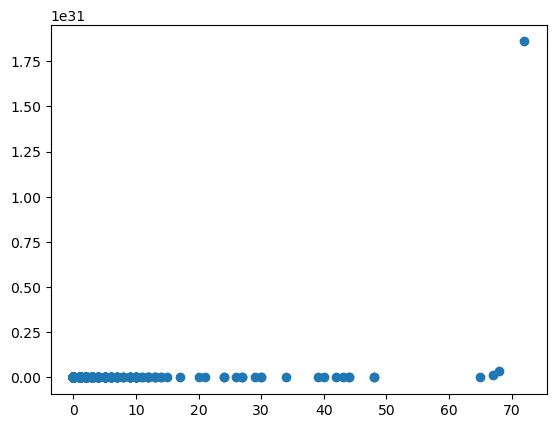

In [24]:
import matplotlib.pyplot as plt
plt.scatter(y[::100], loss[::100])

In [18]:
temp = torch.tensor([1.0, 1.0, 1.0])
loss = F.poisson_nll_loss(temp, temp, log_input=False)
print(loss)

tensor(1.)


In [25]:
temp = torch.tensor([1.0, 1.0, 1.0])*100
loss = F.poisson_nll_loss(temp, temp, log_input=False)
print(loss)
#so in this case when it's highly poisitive it predicts highly positive so makes it overall very negative

tensor(-360.5170)


tensor([inf, inf, inf])

In [31]:
#so we added a small torch.exp to the model output, this way it forces it to be positive and makes the model learn to give small values
#let's test this using exp
temp = torch.tensor([1.0, 1.0, 1.0])*2
loss = F.poisson_nll_loss(torch.exp(temp), temp, log_input=False)
print(loss)

tensor(3.3891)


In [32]:
#let's test it, now say model outputs log(lambda)
real_out = dataset[0][1][0]
print(real_out.shape)

torch.Size([1000000])


In [35]:
out = torch.stack([real_out, real_out, real_out], dim=1)
#and transpose
out = out.transpose(0,1)
print(out.shape) 
#this is like batch size of 3, and 1 million tokens, so we can do this

torch.Size([3, 1000000])


In [43]:
out

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [40]:
#now let's make some test outputs
fake_out = torch.rand(out.shape)*2
fake_out = torch.log(fake_out)

In [41]:
fake_out #some positive and some negative

tensor([[ 0.4153,  0.1411,  0.6568,  ..., -0.6068,  0.4805, -7.8939],
        [ 0.6502, -0.4904,  0.6922,  ..., -0.3562,  0.0782,  0.4096],
        [ 0.1813,  0.3219,  0.6653,  ...,  0.6250, -0.1672,  0.2868]])

In [44]:
#now let's try it
loss = F.poisson_nll_loss(torch.exp(fake_out), out, log_input=True)
print(loss)

tensor(2.4432)


In [ ]:
'''
Ahh, so basically the poisson part comes into penalizing the difference between the actual count
and the real count. For ap oisson if we predict a lambda of 0 but a count is 100 that's incredibly unlikely,
but if we predict a lambda of 2, a real count of 0 is still incredibly likely, is that correct?
Yes that is correct!
The loss is the negative log likelihood of seeing this one piece of data given that mean parameter!!
And we can safely predict that probability of seeing that one data point given the mean parameter
This is a common implementation and makes sense!
'''

In [ ]:
#so now we have an implementation that makes sense!

# finally testing the models

In [2]:
#I trained them, but currently they are all not returning a loss, this tells me they are likely not learning which is not good!
#but let's see it on some random peaks
#first find a peak to test on
import numpy as np
split = 'test'
data_path = f'/data/leslie/sarthak/data/chrombpnet_test/saved_data_1000/{split}/'
peak_coords = np.load(data_path+'peak_coords.npy')
print(peak_coords) #let's stick with the one on chr 11 at 100,576,623

[['chr11' '100576623' 'f' '1']
 ['chr11' '100625242' 'f' '1']
 ['chr11' '100629898' 'f' '1']
 ...
 ['chr12' '99984416' 'f' '1']
 ['chr12' '99984723' 'f' '1']
 ['chr12' '99984997' 'f' '1']]


In [3]:
genome_np = '/data/leslie/sarthak/data/chrombpnet_test/hg38_tokenized.npz'

with np.load(genome_np) as data:
    genome = {key: np.array(data[key]) for key in data}

In [4]:
len(genome['chr11']) #135,086,622

135086622

In [10]:
len(genome['chr12'])

133275309

In [5]:
#hmm, then this peak coords doesn't really make sense? why is it so large??
#is it giving the position in reference to the whole genome??
print(peak_coords.shape)

(26172, 4)


In [8]:
coords = peak_coords[:,1].astype(np.int64)
coords

array([100576623, 100625242, 100629898, ...,  99984416,  99984723,
        99984997])

In [9]:
print(coords.max()) #no doesn't seme to go outside of the 135 million... why is that the limit tho? seems a bit weird that it starts at such a large number already...
#shows that the data may be a bit weird that we are training it on?

135075967


In [13]:
#let's first do the 32k model
width = 32768
start = 100576623 - width//2
end = 100576623 + width//2
data = genome['chr11'][start:end]
print(data.shape)

(32768,)


In [23]:
#and the bigwig file
cts_bw_file = '/data/leslie/sarthak/data/chrombpnet_test/chrombpnet_model_1000/auxiliary/data_unstranded.npz'
with np.load(cts_bw_file) as data:
    cts = {key: np.array(data[key]) for key in data}

In [25]:
trueout = cts['chr11'][start:end]
print(trueout.shape)

(32768,)


In [14]:
#now we have the data, we can easily access it, let's load in the 1 million length models and test it and view what the shape looks like
#let's load in the model
import torch
import sys
import yaml 
from tqdm import tqdm
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.tasks.decoders import SequenceDecoder
import pytorch_lightning as pl
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from torch.utils.data import DataLoader
import torch.nn as nn
from src.dataloaders.datasets.ccre_dataset import CcreDataset
from src.models.sequence.long_conv_lm import ConvLMHeadModel
from src.tasks.decoders import ProfileDecoder
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/profile_long.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-06-29/17-51-37-032877/checkpoints/16-val_loss=nan.ckpt' #it's nan but it's the most recent one, let's just test it?
# train_cfg = cfg['train']
model_cfg = cfg['model_config']
# d_output = train_cfg['d_output']
d_output=1
backbone = DNAEmbeddingModel(**model_cfg)
decoder = ProfileDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')
state_dict = torch.load(ckpt_path, map_location='cpu')
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)
# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
decoder_state_dict['output_transform_counts.weight'] = model_state_dict.pop('decoder.0.output_transform_counts.weight')
decoder_state_dict['output_transform_counts.bias'] = model_state_dict.pop('decoder.0.output_transform_counts.bias')
decoder_state_dict['output_transform_profile.weight'] = model_state_dict.pop('decoder.0.output_transform_profile.weight')
decoder_state_dict['output_transform_profile.bias'] = model_state_dict.pop('decoder.0.output_transform_profile.bias')
# else:
#     for key in list(model_state_dict.keys()):
#         if 'decoder' in key:
#             decoder_state_dict[key[10:]] = model_state_dict.pop(key) #still gotta test this, but I think it'll work
# now actually load the state dict to the decoder and backbone separately
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)
decoder = decoder.to(device).eval()
backbone = backbone.to(device).eval()

In [19]:
#this model is for the multinomial loss, not the poisson one, so this is the type we've looked at before
#th eonly difference is the loss function, else it's identical
tempdata = torch.LongTensor(data).unsqueeze(0).to(device)
print(tempdata.shape)
print(tempdata)

torch.Size([1, 32768])
tensor([[ 8, 10, 10,  ...,  7, 10,  7]], device='cuda:0')


In [20]:
#now put it thorugh the model
out1 = backbone(tempdata)
out2 = decoder(out1[0])
print(out2[0].shape, out2[1].shape)

torch.Size([1, 32768, 1]) torch.Size([1, 1])


In [21]:
profile = out2[0].squeeze().softmax(dim=0).detach().cpu().numpy()
counts = out2[1].squeeze().detach().cpu().numpy()

Text(0.5, 1.0, 'Predicted profile counts for 32k model, multinomial loss')

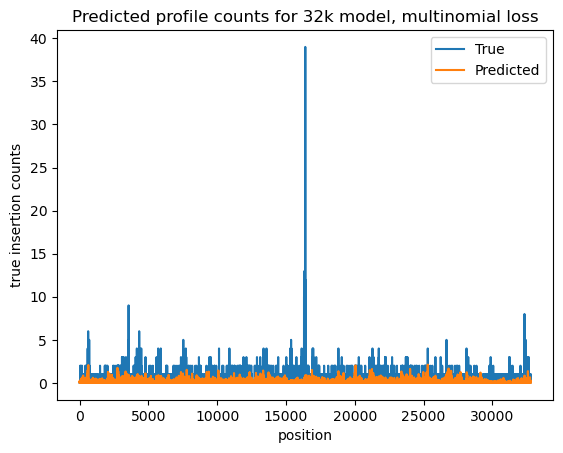

In [31]:
#now let's plot it
import matplotlib.pyplot as plt
plt.plot(trueout)
plt.plot(profile*trueout.sum())
#and add legend
plt.legend(['True', 'Predicted'])
plt.ylabel('true insertion counts')
plt.xlabel('position') #center is the defined peak
plt.title('Predicted profile counts for 32k model, multinomial loss')

In [34]:
#we can also look at the counts data
print(counts)
print(np.log(trueout.sum())) #not far off actually, but maybe because mostly background

7.4679046
8.014666370464942


In [35]:
#and now the other 32k model!
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-06-28/19-12-39-902198/checkpoints/30-val_loss=nan.ckpt'
cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/profile_long.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
# train_cfg = cfg['train']
model_cfg = cfg['model_config']
# d_output = train_cfg['d_output']
d_output=1
backbone = DNAEmbeddingModel(**model_cfg)
decoder = ProfileDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')
state_dict = torch.load(ckpt_path, map_location='cpu')
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)
# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
decoder_state_dict['output_transform_counts.weight'] = model_state_dict.pop('decoder.0.output_transform_counts.weight')
decoder_state_dict['output_transform_counts.bias'] = model_state_dict.pop('decoder.0.output_transform_counts.bias')
decoder_state_dict['output_transform_profile.weight'] = model_state_dict.pop('decoder.0.output_transform_profile.weight')
decoder_state_dict['output_transform_profile.bias'] = model_state_dict.pop('decoder.0.output_transform_profile.bias')
# else:
#     for key in list(model_state_dict.keys()):
#         if 'decoder' in key:
#             decoder_state_dict[key[10:]] = model_state_dict.pop(key) #still gotta test this, but I think it'll work
# now actually load the state dict to the decoder and backbone separately
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)
decoder = decoder.to(device).eval()
backbone = backbone.to(device).eval()

In [36]:
#and now put it through the model
out1 = backbone(tempdata)
out2 = decoder(out1[0])
print(out2[0].shape, out2[1].shape)

torch.Size([1, 32768, 1]) torch.Size([1, 1])


In [43]:
profile = out2[0].squeeze().detach().cpu().numpy()
counts = out2[1].squeeze().detach().cpu().numpy()
print(counts) #fine on counts?

7.3395286


Text(0.5, 1.0, 'Predicted profile counts for 32k model, poisson loss')

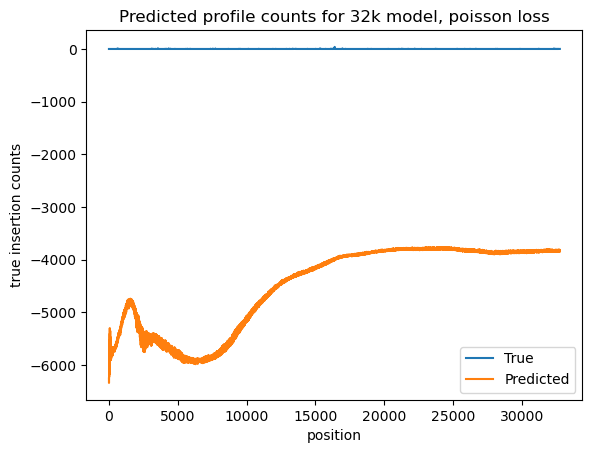

In [41]:
#now let's plot it
import matplotlib.pyplot as plt
plt.plot(trueout)
plt.plot(profile*trueout.sum())
#and add legend
plt.legend(['True', 'Predicted'])
plt.ylabel('true insertion counts')
plt.xlabel('position') #center is the defined peak
plt.title('Predicted profile counts for 32k model, poisson loss')

In [42]:
#it's fine since it's towards the end tho, and still like 35 million more, so it really is fine!
#let's grab the region that is centered around 100576623, 500k left and right
start = 100576623 - 500_000
end = 100576623 + 500_000
print(end-start)

data = genome['chr11'][start:end]
print(data.shape)

1000000
(1000000,)


In [44]:
#this model is for the multinomial loss, not the poisson one, so this is the type we've looked at before
#th eonly difference is the loss function, else it's identical
tempdata = torch.LongTensor(data).unsqueeze(0).to(device)
print(tempdata.shape)
print(tempdata)

torch.Size([1, 1000000])
tensor([[10,  8,  7,  ...,  9,  7, 10]], device='cuda:0')


In [47]:
#so for the 1 million model we can't use the same gpu as the 32k model, so we need to use cpu but for one sample it should be fine?
import torch
import sys
import yaml 
from tqdm import tqdm
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.tasks.decoders import SequenceDecoder
import pytorch_lightning as pl
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from torch.utils.data import DataLoader
import torch.nn as nn
from src.dataloaders.datasets.ccre_dataset import CcreDataset
from src.models.sequence.long_conv_lm import ConvLMHeadModel
from src.tasks.decoders import ProfileDecoder
import numpy as np

device = torch.device('cpu')

cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/profile_long.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
print(cfg['model_config'])
print(cfg['model_config']['layer'])
#the two main changes are number of layers and the length of course
cfg['model_config']['n_layer'] = 8
cfg['model_config']['layer']['l_max'] = 1_000_002

{'_name_': 'dna_embedding', 'd_model': 256, 'n_layer': 4, 'd_inner': 1024, 'vocab_size': 16, 'resid_dropout': 0.0, 'embed_dropout': 0.1, 'fused_mlp': False, 'fused_dropout_add_ln': False, 'residual_in_fp32': True, 'pad_vocab_size_multiple': 1, 'checkpoint_mixer': True, 'checkpoint_mlp': True, 'return_hidden_state': True, 'layer': {'_name_': 'hyena', 'emb_dim': 5, 'filter_order': 64, 'local_order': 3, 'l_max': 32770, 'modulate': True, 'w': 10, 'lr': '6e-4', 'wd': 0.0, 'lr_pos_emb': 0.0}, 'bidirectional': False}
{'_name_': 'hyena', 'emb_dim': 5, 'filter_order': 64, 'local_order': 3, 'l_max': 32770, 'modulate': True, 'w': 10, 'lr': '6e-4', 'wd': 0.0, 'lr_pos_emb': 0.0}


In [49]:
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-06-28/19-12-39-904601/checkpoints/06-val_loss=nan.ckpt' #1 million and poisson loss

In [50]:
#now we have the data, we can easily access it, let's load in the 1 million length models and test it and view what the shape looks like
#let's load in the model

# train_cfg = cfg['train']
model_cfg = cfg['model_config']
# d_output = train_cfg['d_output']
d_output=1
backbone = DNAEmbeddingModel(**model_cfg)
decoder = ProfileDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')
state_dict = torch.load(ckpt_path, map_location='cpu')
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)
# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
decoder_state_dict['output_transform_counts.weight'] = model_state_dict.pop('decoder.0.output_transform_counts.weight')
decoder_state_dict['output_transform_counts.bias'] = model_state_dict.pop('decoder.0.output_transform_counts.bias')
decoder_state_dict['output_transform_profile.weight'] = model_state_dict.pop('decoder.0.output_transform_profile.weight')
decoder_state_dict['output_transform_profile.bias'] = model_state_dict.pop('decoder.0.output_transform_profile.bias')
# else:
#     for key in list(model_state_dict.keys()):
#         if 'decoder' in key:
#             decoder_state_dict[key[10:]] = model_state_dict.pop(key) #still gotta test this, but I think it'll work
# now actually load the state dict to the decoder and backbone separately
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)
decoder = decoder.to(device).eval()
backbone = backbone.to(device).eval()

In [51]:
tempdata = torch.LongTensor(data).unsqueeze(0).to(device)
print(tempdata.shape)
print(tempdata)

torch.Size([1, 1000000])
tensor([[10,  8,  7,  ...,  9,  7, 10]])


In [52]:
#let's now run the data through
out1 = backbone(tempdata)
out2 = decoder(out1[0])

In [53]:
profile = out2[0].squeeze().detach().cpu().numpy()
counts = out2[1].squeeze().detach().cpu().numpy()
print(counts)

nan


In [56]:
#see how much of the profile is nan
np.isnan(profile).sum()/profile.shape[0]
#all of it is nan, perfect... yeah idk about this then?

1.0

In [57]:
#redo it again
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-06-29/17-51-37-034874/checkpoints/03-val_loss=nan.ckpt'
model_cfg = cfg['model_config']
# d_output = train_cfg['d_output']
d_output=1
backbone = DNAEmbeddingModel(**model_cfg)
decoder = ProfileDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')
state_dict = torch.load(ckpt_path, map_location='cpu')
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)
# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
decoder_state_dict['output_transform_counts.weight'] = model_state_dict.pop('decoder.0.output_transform_counts.weight')
decoder_state_dict['output_transform_counts.bias'] = model_state_dict.pop('decoder.0.output_transform_counts.bias')
decoder_state_dict['output_transform_profile.weight'] = model_state_dict.pop('decoder.0.output_transform_profile.weight')
decoder_state_dict['output_transform_profile.bias'] = model_state_dict.pop('decoder.0.output_transform_profile.bias')
# else:
#     for key in list(model_state_dict.keys()):
#         if 'decoder' in key:
#             decoder_state_dict[key[10:]] = model_state_dict.pop(key) #still gotta test this, but I think it'll work
# now actually load the state dict to the decoder and backbone separately
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)
decoder = decoder.to(device).eval()
backbone = backbone.to(device).eval()

In [58]:
#let's now run the data through
out1 = backbone(tempdata)
out2 = decoder(out1[0])

In [59]:
profile = out2[0].squeeze().softmax(dim=0).detach().cpu().numpy()
counts = out2[1].squeeze().detach().cpu().numpy()
print(counts)
#predicted counts is very low

0.7539546


In [60]:
#see how much of the profile is nan
np.isnan(profile).sum()/profile.shape[0]
#all of it is nan, perfect... yeah idk about this then?
#not a single non?? that's good!!

0.0

In [61]:
trueout = cts['chr11'][start:end]
print(trueout.shape)

(1000000,)


In [63]:
print(np.log(trueout.sum())) #should be 11.44

11.441504648408609


Text(0.5, 1.0, 'Predicted profile counts for 32k model, poisson loss')

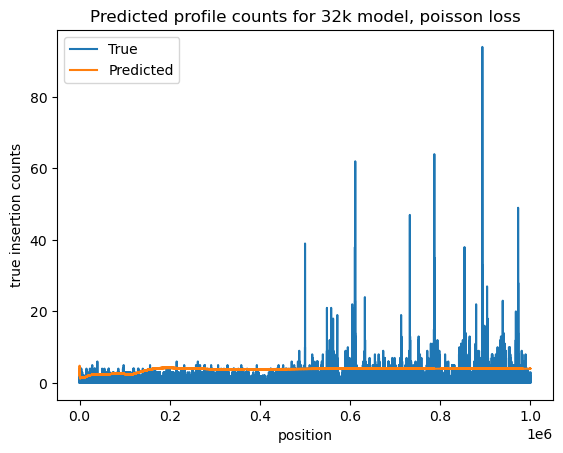

In [65]:
#now let's plot it
import matplotlib.pyplot as plt
plt.plot(trueout)
plt.plot(profile*trueout.sum()*40)
#and add legend
plt.legend(['True', 'Predicted'])
plt.ylabel('true insertion counts')
plt.xlabel('position') #center is the defined peak
plt.title('Predicted profile counts for 1m model, multinomial loss')

In [66]:
(profile*trueout.sum()*40).max()
#it's just really bad, likely because loss becomes non too quickly, onlyu updates for 30 steps or so.

4.81857416917137

# summary

the models aren't learnign becasue it becomes nan, need to figure out and test why this is the case so we can fix it an dmake it more stable overall

This is a major concern and a big roadblock and I am unsure how to approach it...